# Dynamic Nested Sampling of Jones scalars observables (noisy angular quantities) with uncertainty inference

**Disclaimer: there is an issue where the evidence is not converging with the dynamic sampler in the release candidate for 1.0. This will be fixed. Doing a non-dynamic nested sampling with more num_live_points does indeed converge with arbitrary accuracy to the true value.**

This is a simple physics model where our data, $y$, is modelled as the principle argument of a unitary complexy vector with white noise added, i.e. the phase of a complex RV, $\phi_\nu = K \tau \nu^{-1} + M \eta \nu + \epsilon$

$L(x) = p(y | x) = \mathcal{N}[y \mid \phi_{\rm obs},\sigma^2 \mathbf{I}]$

where $\phi_{\rm obs} = \arg Y$ and $Y \sim \mathcal{N}(e^{i \phi}, \sigma^2 \mathbf{I}_{\mathbb{C}})$

and we take the priors,

$p(\tau) = \mathcal{C}[\tau \mid 0, 100]$ (Cauchy)


$p(\eta) = \mathcal{U}[\eta \mid -2, 2]$ (Uniform)


$p(\epsilon) = \mathcal{U}[\epsilon \mid -\pi, \pi]$ (Uniform)


$p(\sigma) = \mathcal{H}[\sigma \mid 0.5]$ (Half-Laplace)





## Overview

We'll cover the following topics:

1. How to define a model using `PriorChain`.
2. How to define _a_ likelihood with angular parameters.
3. How to brute-force compute the evidence for comparison.
4. How to compute Bayesian evidence of your model with **dynamic** nested sampling.
5. How to and plot your results.
6. How to iteratively refine your results until you're happy with the precision.

In [1]:
from jaxns import NestedSampler
from jaxns import plot_diagnostics, plot_cornerplot
from jaxns import summary, analytic_log_evidence
from jaxns.prior_transforms import UniformPrior, PriorChain, HalfLaplacePrior, CauchyPrior
from jax import jit
from jax import numpy as jnp, random
import pylab as plt

In [2]:

TEC_CONV = -8.4479745  #rad*MHz/mTECU
CLOCK_CONV = (2e-3 * jnp.pi)  #rad/MHz/ns


def wrap(phi):
    return (phi + jnp.pi) % (2 * jnp.pi) - jnp.pi


def generate_data(key, uncert):
    """
    Generate gain data where the phase have a clock const and tec component. This is a model of the impact of the ionosphere on the propagation of radio waves, part of radio interferometry:

    phase[:] = tec * (tec_conv / freqs[:]) + clock * (clock_conv * freqs[:]) + const

    then the gains are:

        gains[:] ~ Normal[{cos(phase[:]), sin(phase[:])}, uncert^2 * I]

    phase_obs[:] = ArcTan[gains.imag, gains.real]

    Args:
        key:
        uncert: uncertainty of the gains

    Returns:
        phase_obs, freqs
    """
    freqs = jnp.linspace(121, 166, 24)  #MHz
    tec = 90.  #mTECU
    const = 2.  #rad
    clock = 0.5  #ns
    phase = wrap(tec * (TEC_CONV / freqs) + clock * (CLOCK_CONV * freqs) + const)
    Y = jnp.concatenate([jnp.cos(phase), jnp.sin(phase)], axis=-1)
    Y_obs = Y + uncert * random.normal(key, shape=Y.shape)
    phase_obs = jnp.arctan2(Y_obs[..., freqs.size:], Y_obs[..., :freqs.size])
    return phase, phase_obs, freqs


WARNING[2022-04-06 17:34:33,011]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


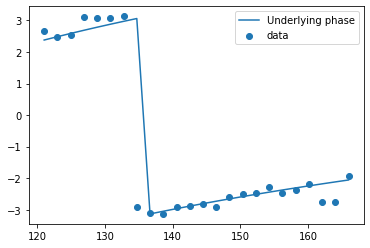

In [3]:
# Generate data
key = random.PRNGKey(43)
key, data_key = random.split(key)
phase_underlying, phase_obs, freqs = generate_data(data_key, 0.25)
plt.scatter(freqs, phase_obs, label='data')
plt.plot(freqs, phase_underlying, label='Underlying phase')
plt.legend()
plt.show()
# Note: the phase wrapping makes this a difficult problem to solve. As we'll see, the posterior is rather complicated.

In [4]:

def log_normal(x, mean, scale):
    dx = (x - mean) / scale
    return -0.5 * jnp.log(2. * jnp.pi) - jnp.log(scale) - 0.5 * dx * dx


def log_likelihood(tec, const, clock, uncert):
    phase = tec * (TEC_CONV / freqs) + const + clock * (CLOCK_CONV * freqs)
    logL = log_normal(wrap(wrap(phase) - wrap(phase_obs)), 0., uncert)
    return jnp.sum(logL)


with PriorChain() as prior_chain:
    CauchyPrior('tec', 0., 100.)
    UniformPrior('const', -jnp.pi, jnp.pi)
    UniformPrior('clock', -2., 2.)
    HalfLaplacePrior('uncert', 0.5)

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3035: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")


In [5]:
# The analytic evidence, from brute-force calculation (warning uses > 2GB RAM)
log_Z = analytic_log_evidence(prior_chain, log_likelihood, S=60)

print(f"True log(Z): {log_Z}")

True log(Z): -4.740489959716797


In [6]:
# We'll use dynamic nested sampling
ns = NestedSampler(log_likelihood, prior_chain, dynamic=True)

# We'll be interested in also refining the solution later, so we'll also return the state.
# Since return_state invokes a python switch, we need to make it a static argument when jit-compiling.
# For a dynamic goal, we'll to minimise evidence uncertainty, G -> 0.
# For a dynamic termination condition, we'll start with log_Z uncertainty < 0.1

results, state = ns(key,
                 G=0.,
                 termination_evidence_uncert=0.05,
                 return_state=True,
                   adaptive_evidence_stopping_threshold=0.05,
                    adaptive_evidence_patience=1)


WARNING[2022-04-06 17:34:35,436]: Increasing max_samples (100000) by 400 to evenly divide samples_per_step
WARNING[2022-04-06 17:34:35,449]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2983: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3035: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncate

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3008: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in full is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "full")
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3035: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")
/home/albert/miniconda3/envs/jax_py/lib/

In [7]:
#Let's look at what we have so far.
summary(results)

--------
Termination Conditions:
Evidence uncertainty low enough
--------
# likelihood evals: 7697083
# samples: 22000
# likelihood evals / sample: 349.9
--------
logZ=-4.361 +- 0.068
H=52.0
ESS=3940
--------
clock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
clock: -0.54 +- 0.68 | -1.12 / -0.69 / 0.33 | -0.75 | -1.65
--------
const: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
const: 1.7 +- 1.9 | -1.9 / 2.6 / 3.1 | 2.4 | -1.7
--------
tec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
tec: 82.0 +- 12.0 | 68.0 / 84.0 / 92.0 | 76.0 | 100.0
--------
uncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
uncert: 0.212 +- 0.034 | 0.174 / 0.207 / 0.257 | 0.183 | 0.193
--------


'--------\nTermination Conditions:\nEvidence uncertainty low enough\n--------\n# likelihood evals: 7697083\n# samples: 22000\n# likelihood evals / sample: 349.9\n--------\nlogZ=-4.361 +- 0.068\nH=52.0\nESS=3940\n--------\nclock: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nclock: -0.54 +- 0.68 | -1.12 / -0.69 / 0.33 | -0.75 | -1.65\n--------\nconst: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nconst: 1.7 +- 1.9 | -1.9 / 2.6 / 3.1 | 2.4 | -1.7\n--------\ntec: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\ntec: 82.0 +- 12.0 | 68.0 / 84.0 / 92.0 | 76.0 | 100.0\n--------\nuncert: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.\nuncert: 0.212 +- 0.034 | 0.174 / 0.207 / 0.257 | 0.183 | 0.193\n--------'

In [8]:
# We can look at how each iteration reduced evidence uncertainty. It looks like the evidence is going down slowly.
results.thread_stats.evidence_uncert

DeviceArray([0.        , 0.76083434, 0.7560215 , 0.5900321 , 0.49617544,
             0.27345493, 0.21606983, 0.16014434, 0.14388315, 0.13195524,
             0.12901348, 0.12871745, 0.12903565, 0.1283316 , 0.12848757,
             0.12848386, 0.11741108, 0.11020671, 0.10385824, 0.09686447,
             0.09283253, 0.08725902, 0.0847277 , 0.08208065, 0.07893109,
             0.07750917, 0.07680464, 0.07364959, 0.0728865 , 0.06974735,
             0.06788865, 0.06600291, 0.06537136, 0.06445497, 0.06246566,
             0.06235296, 0.05908607, 0.05957832, 0.0593799 , 0.05904166,
             0.05807058, 0.05685699, 0.05679826, 0.05353754, 0.05549677,
             0.0529892 , 0.05454126, 0.05348853, 0.05401415, 0.05220957,
             0.05293743, 0.05054831, 0.0505766 , 0.05293068, 0.04787398,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.

WARNING[2022-04-06 17:35:02,045]: No handles with labels found to put in legend.
WARNING[2022-04-06 17:35:02,239]: No handles with labels found to put in legend.


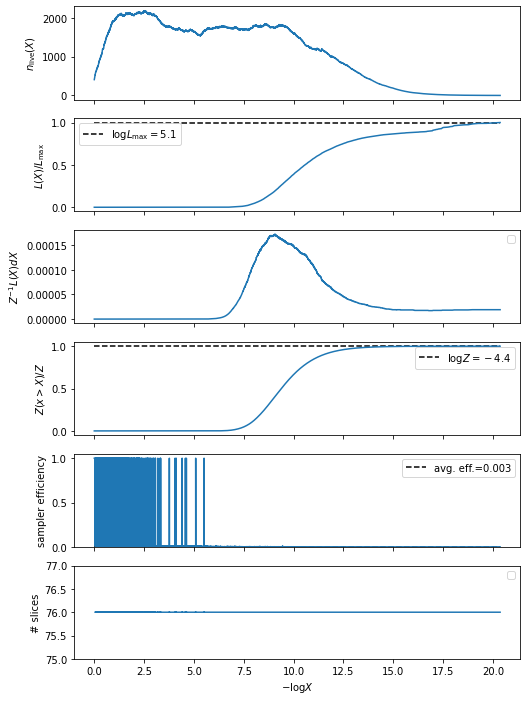

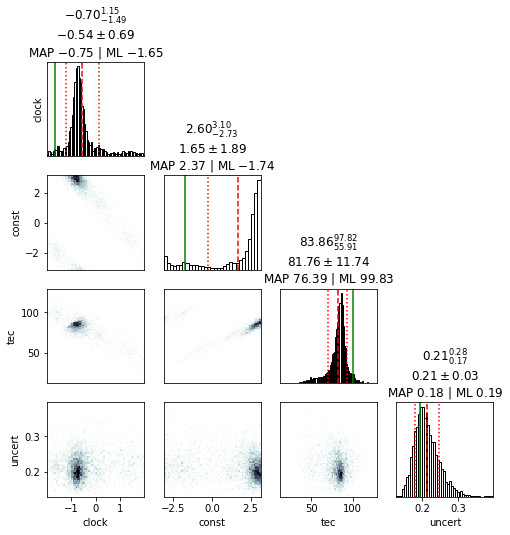

In [9]:
# Finally let's look at the results.
plot_diagnostics(results)
plot_cornerplot(results)

# We can see that the sampler focused more on the initial part of the enclosed prior volume when -logX < 7.5.
# This is evident in the increased n_live points.